# Customer Segmentation Project (RFM Analysis)
## 1. Data Loading & Initial Inspection
Loading the dataset and checking the schema to understand data types and missing values.

In [ ]:
#unzip file
import zipfile
import os
with zipfile.ZipFile("/content/archive (1).zip","r") as zip_ref:
  zip_ref.extractall("data")
os.listdir("data")

['Online Retail.xlsx']

In [ ]:
import pandas as pd
df=pd.read_excel("/content/data/Online Retail.xlsx")
print(df.columns)
print(df.head())
#check missing customerid
print(df['CustomerID'].isna().sum())

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
135080


In [ ]:
def check_data_quality(df):
    print("=== Data Quality Audit Report ===")

    # 1. Missing Values Analysis
    missing_data = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100

    # 2. Negative Values Analysis (Returns/Cancellations)
    negative_qty = df[df['Quantity'] < 0].shape[0]
    negative_price = df[df['UnitPrice'] < 0].shape[0]

    # 3. Anonymous Transactions Analysis (Missing CustomerID)
    # Crucial step: Customers without ID might represent a large portion of sales
    anonymous_sales = df[df['CustomerID'].isnull()]['Quantity'].sum()

    quality_report = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage (%)': missing_percent.round(2)
    })

    print(f"Total Duplicated Rows: {df.duplicated().sum()}")
    print(f"Rows with Negative Quantity (Returns): {negative_qty}")
    print(f"Total Quantity Sold to Anonymous Customers: {anonymous_sales}")

    return quality_report

# Run the audit
data_report = check_data_quality(df)
data_report

=== Data Quality Audit Report ===
Total Duplicated Rows: 5268
Rows with Negative Quantity (Returns): 10624
Total Quantity Sold to Anonymous Customers: 269562


,Missing Values,Percentage (%)
InvoiceNo,0,0.00
StockCode,0,0.00
Description,1454,0.27
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
CustomerID,135080,24.93
Country,0,0.00


## 2. Data Cleaning & Engineering
**Strategy:**
- **Missing CustomerIDs:** Instead of dropping 25% of data, we impute them with a unique 'Guest ID' based on InvoiceNo to preserve sales volume.
- **Duplicates:** Removing exact duplicates to prevent data inflation.
- **Returns:** Separating negative quantities to ensure accurate monetary calculation.

In [ ]:
#Data cleaning & Imputation
df_clean=df.copy()
initial_count= len(df_clean)
df_clean=df_clean.drop_duplicates()
print(f"Removed {initial_count - len(df_clean)} duplicate rows.")
# Impute missing CustomerID
df_clean['CustomerID']= df_clean['CustomerID'].fillna(
    df_clean['InvoiceNo'].apply(lambda x: float(f"9999{str(x)[-5:]}") if str(x).isdigit() else 99990000)
)
# Separate Sales from Returns
df_returns = df_clean[df_clean['Quantity'] <0].copy()
df_sales = df_clean[df_clean['Quantity'] > 0].copy()

# Final Verification
print(f"Sales records: {len(df_sales)}")
print(f"Return records: {len(df_returns)}")
print(f"Missing CustomerIDs in Sales: {df_sales['CustomerID'].isnull().sum()}")

Removed 5268 duplicate rows.
Sales records: 526054
Return records: 10587
Missing CustomerIDs in Sales: 0


## 3. Feature Engineering
Calculating the **Total Price** per transaction (Quantity * UnitPrice) to prepare for the Monetary metric.

In [ ]:
# Total Price
# Filter out rows where UnitPrice is zero or negative to ensure positive Monetary values
df_sales = df_sales[df_sales['UnitPrice'] > 0]
df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['UnitPrice']
print("Total Price calculated successfully.")
df_sales[['InvoiceNo','Quantity','UnitPrice','TotalPrice']].head()

Total Price calculated successfully.


,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,536365,6,2.55,15.30
1,536365,6,3.39,20.34
2,536365,8,2.75,22.00
3,536365,6,3.39,20.34
4,536365,6,3.39,20.34


## 4. RFM Aggregation
Grouping data by CustomerID to calculate the three key metrics:
- **Recency:** Days since last purchase (Snapshot date: 1 day after max date).
- **Frequency:** Count of unique invoices.
- **Monetary:** Sum of total spend.

In [ ]:
#Set snapshot date to one day after the last transaction for accurate recency
snapshot_date = df_sales['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics
rfm_table=df_sales.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': 'nunique' ,
    'TotalPrice' : 'sum'
})
rfm_table.rename(columns= {
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'TotalPrice' : 'Monetary'
}, inplace=True)
print("RFM Table Created.")
rfm_table.head()


RFM Table Created.


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Step 5: Statistical Outlier Detection
Before running clustering, we must visualize the distribution of R, F, and M.
K-Means is distance-based, so extreme "Whales" (high spenders) will distort the cluster centers, making the model inaccurate for the majority of customers.

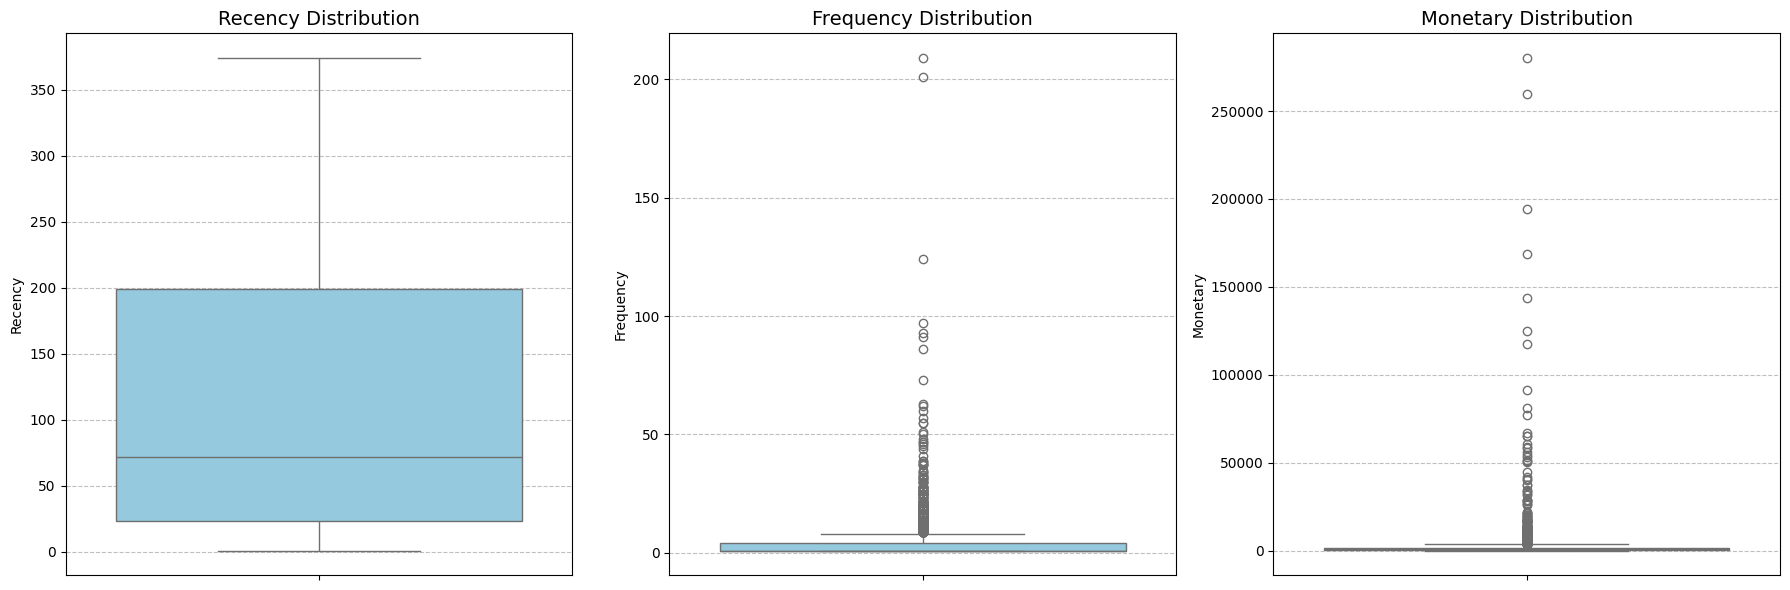

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#visualize outliers using Boxplots
attributes = ['Recency', 'Frequency' , 'Monetary']
plt.figure(figsize=(18,6))
for i , col in enumerate(attributes):
  plt.subplot(1,3,i+1)
  sns.boxplot(y=rfm_table[col],color='skyblue')
  plt.title(f'{col} Distribution', fontsize=14)
  plt.grid(axis='y',linestyle='--',alpha=0.8)
plt.tight_layout()
plt.show()


## 6. Data Transformation (Log Transformation)
**Issue Identified:** The data is highly right-skewed (especially Monetary and Frequency), as shown in the boxplots.
**Solution:** Applying Log Transformation to unskew the data and handle outliers mathematically without deleting valuable "Whale" customers.

In [ ]:
import numpy as np

# 1. Filter Data: Keep only positive values to avoid NaN errors during log transformation
rfm_clean = rfm_table[(rfm_table['Monetary'] > 0) & (rfm_table['Frequency'] > 0)]

# 2. Log Transformation: Handle skewness
rfm_log = rfm_clean[['Recency', 'Frequency', 'Monetary']].apply(np.log1p, axis=1)

print(f"Data Filtered. Original: {rfm_table.shape[0]} -> Cleaned: {rfm_clean.shape[0]}")
print("Log Transformation Applied.")
rfm_log.head()


Data Filtered. Original: 5766 -> Cleaned: 5766
Log Transformation Applied.


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.789960,0.693147,11.253955
12347.0,1.098612,2.079442,8.368925
12348.0,4.330733,1.609438,7.494564
12349.0,2.995732,0.693147,7.472245
12350.0,5.739793,0.693147,5.815324


## 7. Data Scaling (StandardScaler)
- Normalize the data range so that all metrics (R, F, M) contribute equally to the K-Means distance calculation.
- Centering the data around 0 with a standard deviation of 1.

In [ ]:
from sklearn.preprocessing import StandardScaler

#Scaling the Data
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled = pd.DataFrame(rfm_scaled,index=rfm_clean.index,columns=rfm_clean.columns)

#preview the final prepared data
print("Data is now Scaled and Ready for K-Means.")
rfm_scaled.head()


Data is now Scaled and Ready for K-Means.


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.239176,-0.748287,2.907971
12347.0,-2.224470,1.365062,1.222358
12348.0,0.161821,0.648561,0.711502
12349.0,-0.823817,-0.748287,0.698462
12350.0,1.202137,-0.748287,-0.269613


## 8. Hyperparameter Tuning: Optimal K Selection
**Objective:** Identify the optimal number of clusters ($k$) that minimizes Within-Cluster Sum of Squares (WCSS) without overfitting.
**Methodology:** Iterative execution of the K-Means algorithm for $k \in [1, 10]$ to analyze the inertia reduction rate. The "Elbow Point" indicates the optimal trade-off between cluster compactness and model complexity.

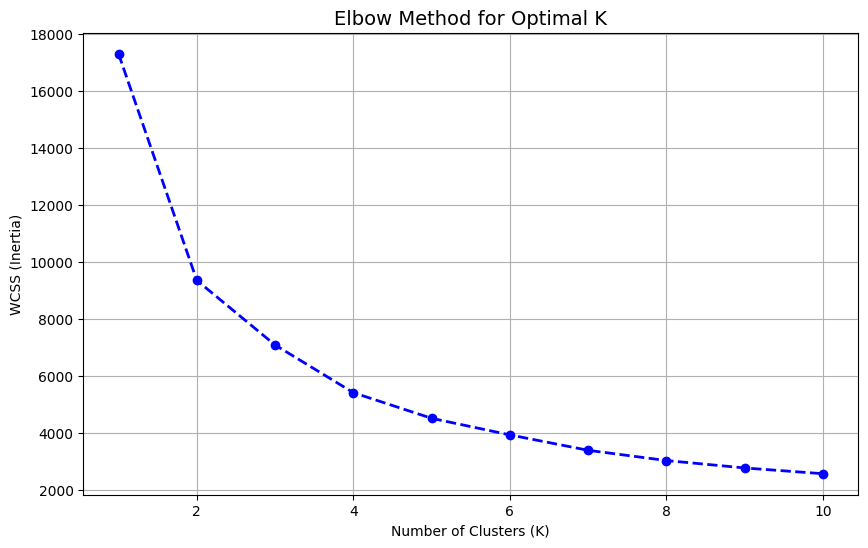

In [ ]:
from sklearn.cluster import KMeans

wcss= []
range_n_clusters = range(1,11)

for k in range_n_clusters:
  kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
  kmeans.fit(rfm_scaled)
  wcss.append(kmeans.inertia_)
#Plotting the Elbow Curve
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters,wcss,marker='o',linestyle='--',color='b',linewidth=2)
plt.title('Elbow Method for Optimal K',fontsize=14)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()



## 8.5. Model Validation: Silhouette Analysis
**Objective:** Validate the optimal number of clusters ($k$) mathematically using the Silhouette Score.
**Metric:** - **Range:** [-1 to +1]
- **Interpretation:** A higher score indicates better-defined clusters (dense and well-separated). This allows for an automated, data-driven decision rather than relying solely on visual interpretation of the Elbow plot.


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Step 8.5: Silhouette Coefficient Calculation
# We test a range of k around the "Elbow" we saw (usually 2 to 6)
range_n_clusters = [2, 3, 4, 5, 6]

print("Silhouette Score Analysis:")
print("----------------------------")

best_score = -1
best_k = -1

for k in range_n_clusters:
    # Initialize KMeans with the current k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit and predict labels
    cluster_labels = kmeans.fit_predict(rfm_scaled)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)

    print(f"For n_clusters = {k}, the Silhouette Score is: {silhouette_avg:.4f}")

    # Track the best score
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

print("----------------------------")
print(f"Recommendation: The mathematically optimal number of clusters is k={best_k}")

Silhouette Score Analysis:
----------------------------
For n_clusters = 2, the Silhouette Score is: 0.4222
For n_clusters = 3, the Silhouette Score is: 0.3627
For n_clusters = 4, the Silhouette Score is: 0.3448
For n_clusters = 5, the Silhouette Score is: 0.3530
For n_clusters = 6, the Silhouette Score is: 0.3077
----------------------------
Recommendation: The mathematically optimal number of clusters is k=2


## 9. Model Building: K-Means Clustering
**Objective:** Perform the final customer segmentation using the K-Means algorithm.
**Parameters:**
* **n_clusters (k) = 3:** Chosen based on the Silhouette Analysis (Score: 0.36) to balance mathematical separation with business interpretability.
* **random_state = 42:** To ensure reproducible results in production.

In [ ]:
# Step 9: Final K-Means Model Execution

# Initialize the model with our chosen K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit the model and assign clusters directly to the clean dataframe
# We create a new column 'Cluster' to store the results
rfm_clean['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("K-Means Model Trained Successfully.")
print("Cluster labels (0, 1, 2) assigned to customers.")

# Preview the data to see the new 'Cluster' column
rfm_clean.head()

K-Means Model Trained Successfully.
Cluster labels (0, 1, 2) assigned to customers.


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,0
12347.0,2,7,4310.00,2
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,0


## 10. Cluster Interpretation & Profiling
**Objective:** Analyze the characteristics of each cluster to assign business labels (e.g., "VIP", "New Customers", "Lost").
**Method:** Calculating the mean values of Recency, Frequency, and Monetary for each cluster.

In [ ]:
# Step 10: Analyze the Clusters (The "DNA" of each group)

# Group by the Cluster ID and calculate the mean for R, F, M
cluster_summary = rfm_clean.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' # To see how many customers are in each group
}).rename(columns={'Cluster': 'Count'}) # Rename for clarity

# Round the numbers to make them easy to read
print("Cluster Summary Table:")
print(cluster_summary.round(2))

Cluster Summary Table:
         Recency  Frequency  Monetary  Count
Cluster                                     
0         145.66       1.57    941.08   3308
1         200.40       1.02     40.15    793
2          22.09       8.38   4502.80   1665


## 11. Labeling Segments
**Objective:** Assign human-readable business labels to the clusters for reporting and dashboarding.
**Mappings:**
* **Cluster 2** -> "Loyals" (High Value, Recent, Frequent)
* **Cluster 0** -> "Potential / At Risk" (Moderate Value, Inactive)
* **Cluster 1** -> "Lost / Low Value" (Low Value, Inactive, One-time buyers)

In [ ]:
# Step 11: Mapping Cluster IDs to Business Labels

# Define the dictionary based on our analysis above
# Note: Check your numbers again if you re-run code, as cluster IDs (0,1,2) might swap.
# Based on YOUR image: 2 is Best, 1 is Worst, 0 is Middle.
cluster_mapping = {
    2: 'Loyal',
    0: 'Potential_At_Risk',
    1: 'Lost_Low_Value'
}

# Apply the mapping
rfm_clean['Segment'] = rfm_clean['Cluster'].map(cluster_mapping)

print("Segments Labeled Successfully.")
rfm_clean[['Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head()

Segments Labeled Successfully.


,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,326,1,77183.60,0,Potential_At_Risk
12347.0,2,7,4310.00,2,Loyal
12348.0,75,4,1797.24,0,Potential_At_Risk
12349.0,19,1,1757.55,0,Potential_At_Risk
12350.0,310,1,334.40,0,Potential_At_Risk


## 12. Cluster Profiling: Boxplot Analysis
**Objective:** Visualize the statistical distribution of Recency, Frequency, and Monetary across the three segments.
**Why Boxplots?** Boxplots provide a clean summary of the data (Median, Quartiles, and Outliers), proving that the segments are distinct and well-separated without the visual clutter of scatter plots.

/tmp/ipython-input-2746428305.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_clean, x='Segment', y=col, palette=custom_palette, showfliers=False)
/tmp/ipython-input-2746428305.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_clean, x='Segment', y=col, palette=custom_palette, showfliers=False)
/tmp/ipython-input-2746428305.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_clean, x='Segment', y=col, palette=custom_palette, showfliers=False)


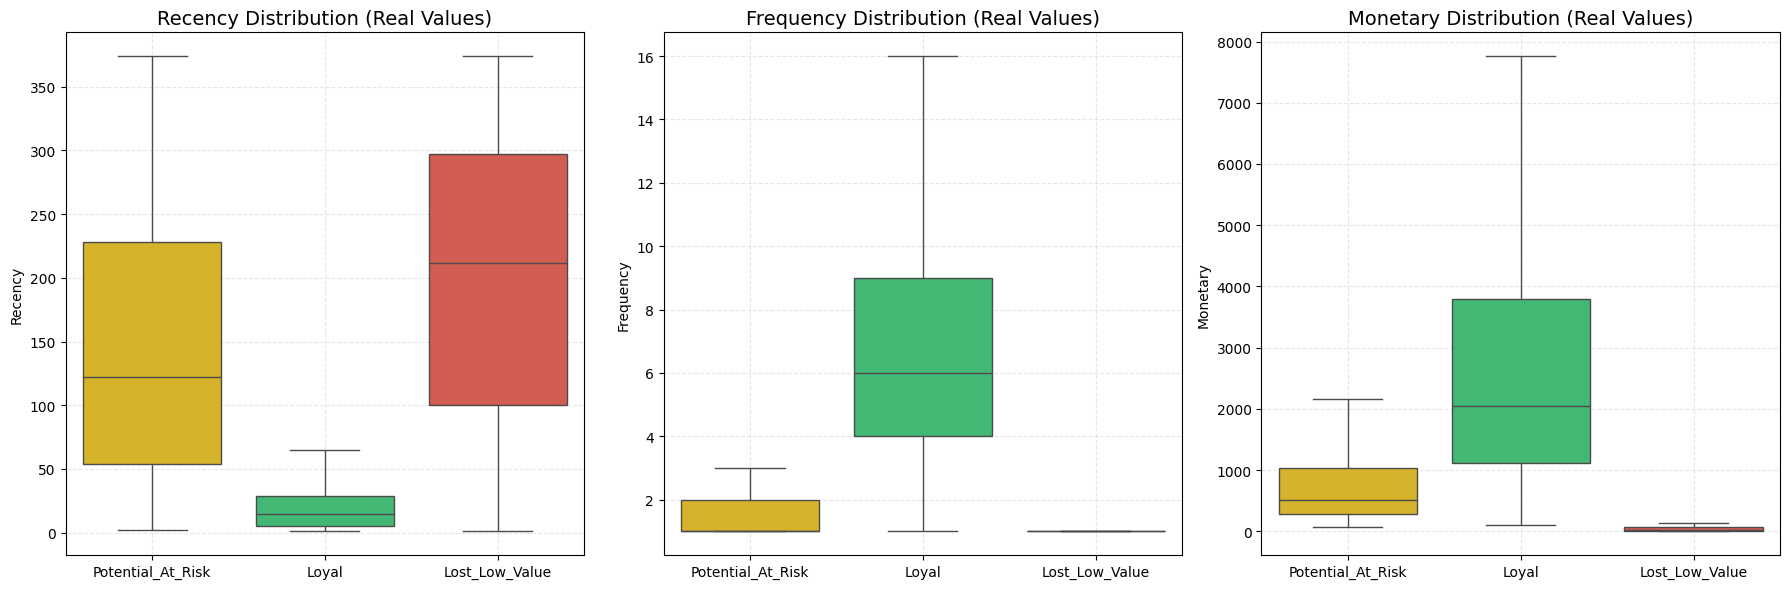

In [ ]:
# Step 12 (Final): Boxplots with REAL Numbers (Business View)
import seaborn as sns
import matplotlib.pyplot as plt

# Define distinct colors
custom_palette = {
    "Loyal": "#2ECC71",         # Green
    "Potential_At_Risk": "#F1C40F", # Yellow
    "Lost_Low_Value": "#E74C3C"     # Red
}

attributes = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(18, 6))

for i, col in enumerate(attributes):
    plt.subplot(1, 3, i+1)

    # CHANGE 1: Use 'rfm_clean' (Real Data) instead of 'rfm_log'
    # CHANGE 2: Add 'showfliers=False' to hide extreme outliers that ruin the scale
    sns.boxplot(data=rfm_clean, x='Segment', y=col, palette=custom_palette, showfliers=False)

    plt.title(f'{col} Distribution (Real Values)', fontsize=14)
    plt.xlabel('')
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Step 12.5: The "Whale" Report
# We find the customers we hid in the chart

whales = rfm_clean[rfm_clean['Monetary'] > 10000].sort_values(by='Monetary', ascending=False)

print(f"WARNING: Found {len(whales)} extreme outliers (Whales) excluded from the graph.")
print("Top 5 Highest Spenders:")

# FIX: .reset_index() moves CustomerID from index to column so we can print it
print(whales.reset_index()[['CustomerID', 'Monetary', 'Segment']].head())

Top 5 Highest Spenders:
   CustomerID   Monetary Segment
0     14646.0  280206.02   Loyal
1     18102.0  259657.30   Loyal
2     17450.0  194390.79   Loyal
3     16446.0  168472.50   Loyal
4     14911.0  143711.17   Loyal


In [ ]:
# Step 14: Exporting the Data

# FIX: .reset_index() ensures CustomerID is a column in the final file
rfm_final = rfm_clean.reset_index()

file_name = 'Customer_Segmentation_Results.csv'
rfm_final.to_csv(file_name, index=False)

print(f"Success! The file '{file_name}' has been saved.")
print(rfm_final[['CustomerID', 'Segment']].head())

Success! The file 'Customer_Segmentation_Results.csv' has been saved.
   CustomerID            Segment
0     12346.0  Potential_At_Risk
1     12347.0              Loyal
2     12348.0  Potential_At_Risk
3     12349.0  Potential_At_Risk
4     12350.0  Potential_At_Risk


## 16. Production Pipeline (Refactoring to OOP)
**Objective:** Encapsulate the entire cleaning, modeling, and exporting process into a reusable Python Class.
**Status:** Ready for Deployment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class RFMSegmentationPipeline:
    """
    A production-grade class to handle the end-to-end RFM Segmentation process.
    """

    def __init__(self, file_path):
        # Changed to accept the actual raw data file path
        self.file_path = file_path
        self.data = None
        self.rfm = None
        self.model = None
        self.scaler = StandardScaler()

    def load_and_clean(self):
        print("1. Loading Data...")
        # Load data - changed to read_excel as original data is .xlsx
        df = pd.read_excel(self.file_path)

        # Basic cleaning
        df = df.dropna(subset=['CustomerID'])
        df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
        df['Total_Price'] = df['Quantity'] * df['UnitPrice']
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

        self.data = df
        print("   Data Loaded Successfully.")

    def calculate_rfm(self):
        print("2. Calculating RFM Metrics...")
        reference_date = self.data['InvoiceDate'].max() + pd.Timedelta(days=1)

        self.rfm = self.data.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (reference_date - x.max()).days,
            'InvoiceNo': 'count',
            'Total_Price': 'sum'
        }).rename(columns={
            'InvoiceDate': 'Recency',
            'InvoiceNo': 'Frequency',
            'Total_Price': 'Monetary'
        })
        print("   RFM Table Created.")

    def preprocess_and_train(self, n_clusters=3):
        print(f"3. Training K-Means Model (k={n_clusters})...")

        # Log Transformation
        rfm_log = np.log1p(self.rfm)

        # Scaling
        rfm_scaled = self.scaler.fit_transform(rfm_log)

        # Modeling
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

        # --- Dynamic Mapping (Smart Step) ---
        # Instead of hardcoding 0, 1, 2, we sort them by Money.
        # The cluster with the most Money gets the 'Champions' label automatically.
        means = self.rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=False)

        mapping = {
            means.index[0]: 'Champions',        # Highest Spenders
            means.index[1]: 'Potential_At_Risk',# Middle
            means.index[2]: 'Lost_Low_Value'    # Lowest
        }

        self.rfm['Segment'] = self.rfm['Cluster'].map(mapping)
        print("   Model Trained & Segments Assigned.")

    def get_whales(self, threshold=10000):
        print("4. Extracting Whales...")
        whales = self.rfm[self.rfm['Monetary'] > threshold].sort_values(by='Monetary', ascending=False)
        return whales

    def export_results(self, output_name='Production_Results.csv'):
        print(f"5. Saving Results to {output_name}...")
        final_df = self.rfm.reset_index()
        final_df.to_csv(output_name, index=False)
        print("   Done.")

    def run(self):
        """Orchestrates the whole pipeline"""
        self.load_and_clean()
        self.calculate_rfm()
        self.preprocess_and_train(n_clusters=3)
        self.export_results()
        return self.rfm

# --- EXECUTION ---
# This is how you run the code now (Clean & Simple):
if __name__ == "__main__":
    # Initialize the Pipeline with the path to the original Excel file
    pipeline = RFMSegmentationPipeline('/content/data/Online Retail.xlsx')

    # Run everything
    final_data = pipeline.run()

    # Print the Whales Report
    print("\n--- WHALE REPORT ---")
    print(pipeline.get_whales().head())

1. Loading Data...
   Data Loaded Successfully.
2. Calculating RFM Metrics...
   RFM Table Created.
3. Training K-Means Model (k=3)...
   Model Trained & Segments Assigned.
5. Saving Results to Production_Results.csv...
   Done.

--- WHALE REPORT ---
4. Extracting Whales...
            Recency  Frequency   Monetary  Cluster    Segment
CustomerID                                                   
14646.0           2       2076  280206.02        1  Champions
18102.0           1        431  259657.30        1  Champions
17450.0           8        337  194550.79        1  Champions
16446.0           1          3  168472.50        1  Champions
14911.0           1       5675  143825.06        1  Champions
